In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import numpy as np;
import pandas as pd;
import os;
import matplotlib.pyplot as plt;
from pandas import *
from textwrap import wrap
import sklearn
import pickle
import glob
import os
%matplotlib inline
import matplotlib.font_manager as font_manager
from math import sqrt
import scipy as sp

import matplotlib.patches as mpatches
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import cross_val_score


import statsmodels
import statsmodels.stats.diagnostic as sms
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as smt


[(1.0, 0.4745098039215686, 0.4235294117647059), (0.0392156862745098, 0.2627450980392157, 0.47843137254901963), (0.0392156862745098, 0.2627450980392157, 0.47843137254901963), (0.5294117647058824, 0.6823529411764706, 0.45098039215686275)]


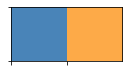

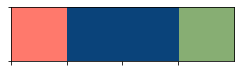

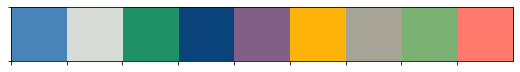

In [2]:
# col_list = ["cool blue", "light grey", "viridian", "twilight blue", 
#              "dusty purple",  "amber", "greyish", "faded green"]
# sns.palplot(sns.xkcd_palette(col_list))
# col_list_palette = sns.xkcd_palette(col_list)

col_list = ["cool blue",  "light orange"]
sns.palplot(sns.xkcd_palette(col_list))
col_list_palette = sns.xkcd_palette(col_list)

col_list2 = ['salmon',"twilight blue",  "twilight blue","sage"]
sns.palplot(sns.xkcd_palette(col_list2))
col_list_palette2 = sns.xkcd_palette(col_list2)

col_list3 = ["cool blue", "light grey", "viridian", "twilight blue", 
             "dusty purple",  "amber", "greyish", "faded green",'salmon']
sns.palplot(sns.xkcd_palette(col_list3))
col_list_palette3 = sns.xkcd_palette(col_list3)

title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}
sub_plot = {'fontname':'Arial', 'size':'18','color':'black', 
            'weight':'bold','horizontalalignment':'left', 'verticalalignment':'center'}

# Set the font properties (for use in legend)   
font_path = 'C:\Windows\Fonts\Arial.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
print(col_list_palette2)



In [7]:
# # col_list = ["cool blue", "light grey", "viridian", "twilight blue", 
# #              "dusty purple",  "amber", "greyish", "faded green"]
# # sns.palplot(sns.xkcd_palette(col_list))
# # col_list_palette = sns.xkcd_palette(col_list)

# col_list = ["cool blue",  "light orange"]
# sns.palplot(sns.xkcd_palette(col_list))
# col_list_palette = sns.xkcd_palette(col_list)

# col_list2 = ['salmon',"cool blue",  'sage',"light orange"]
# sns.palplot(sns.xkcd_palette(col_list2))
# col_list_palette2 = sns.xkcd_palette(col_list2)

# import veg indices data

In [8]:
path1= r'gndvi_thirds'
path2= r'ndvi_thirds'
path3= r'sr_thirds'

def concat(path):
    global f
    f=[]
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []

    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=0)
        df['Source'] = os.path.basename(file_)
        list_.append(df)
    f = pd.concat(list_)   
    f['Date']=f.Source.str.extract('(\d+)')
    f['Cell']=f['Cell_Third'].astype(str).str[0]
    f['year'] =  [x[:4] if isinstance(x, str) else np.nan for x in f['Date']]
    f['year']=f['year'].astype(str)
    
    return f


concat(path1)
GNDVI_core=f
GNDVI_core['GNDVI']=GNDVI_core['MEAN'].copy()

concat(path2)
NDVI_core=f
NDVI_core['NDVI']=NDVI_core['MEAN'].copy()

concat(path3)
SR_core=f
SR_core['SR']=SR_core['MEAN'].copy()

In [9]:
veg = pd.merge(GNDVI_core,NDVI_core[['Cell_Third','Cell','Date','year','NDVI']],how = 'left', on = ['Date','Cell_Third'])
veg = pd.merge(veg,SR_core[['Cell_Third','Cell','Date','year','SR']],how = 'left', on = ['Date','Cell_Third'])
veg=veg[['Cell_Third','Cell','Date','year','GNDVI','NDVI','SR']].copy()

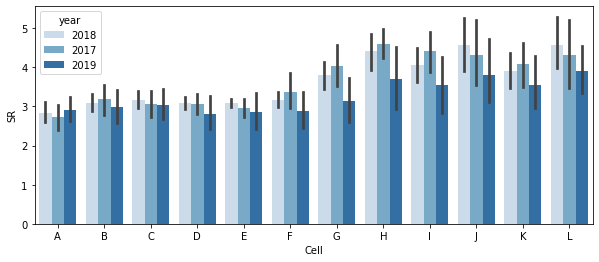

In [10]:
fig,axes = plt.subplots(1,sharex=True,figsize= (10,4))

veg=veg.sort_values('Cell')
sns.barplot(veg['Cell'],veg['SR'],hue=veg['year'],palette='Blues')

# import biomass data

In [40]:
#import biomass csv
biomass=pd.read_csv('biomass_py.csv')
biomass['Date']=biomass['Date'].astype(str).copy()
biomass['Date_planet']=biomass['Date_planet'].astype(str).copy()
biomass['year'] =  [x[:4] if isinstance(x, str) else np.nan for x in biomass['Date']]


In [41]:
#merge biomass and veg indices
biomass_merged = pd.merge(veg,
                          biomass[['MEAN_Bioma','Date','Date_planet','Cell_Third']],
                          left_on=['Date','Cell_Third'],right_on=['Date_planet','Cell_Third']).dropna()
#make a 'cell' field
biomass['Cell']=biomass['Cell_Third'].astype(str).str[0]

#create pivot table to compute mean veg indices for each date
table = pd.DataFrame((pd.pivot_table(biomass_merged, values=['MEAN_Bioma', 'NDVI','GNDVI','SR','year'], 
                       index=['Date_planet','Cell_Third'],
                       aggfunc={'MEAN_Bioma': np.mean,'NDVI': np.mean,'GNDVI': np.mean,'SR': np.mean})).to_records())
table['2019']=pd.np.where(table.Date_planet.str.contains("2019"),2019,0)
table['2017']=pd.np.where(table.Date_planet.str.contains("2017"),2017,0)
table['year']=(table['2019']+table['2017']).astype(str)
core_reg=table[['year','Date_planet','GNDVI','NDVI','SR','MEAN_Bioma','Cell_Third']].copy()
core_reg['Cell']=core_reg['Cell_Third'].astype(str).str[0]

#export to .csv
core_reg.to_csv('core_reg.csv')

year Date_planet     GNDVI      NDVI        SR  MEAN_Bioma Cell_Third Cell
0   2017    20170403  0.532562  0.498522  3.102319    0.336508         A1    A
1   2017    20170403  0.536899  0.496325  3.092703    0.393791         A2    A
2   2017    20170403  0.544674  0.511285  3.227776    0.580741         A3    A
3   2017    20170403  0.607269  0.574990  3.741267    0.128791         B1    B
4   2017    20170403  0.613121  0.572669  3.684461    0.432512         B2    B
5   2017    20170403  0.593968  0.561745  3.570425    0.215483         B3    B
6   2017    20170403  0.595590  0.550343  3.452219    0.332711         C1    C
7   2017    20170403  0.608080  0.562689  3.577724    0.402817         C2    C
8   2017    20170403  0.594456  0.542078  3.374187    0.451848         C3    C
9   2017    20170403  0.592070  0.548190  3.438062    0.218309         D1    D
10  2017    20170403  0.604271  0.554885  3.504497    0.718732         D2    D
11  2017    20170403  0.563162  0.514043  3.134028    0.045099         D3    D
12  2017    20170403  0.575882  0.535990  3.322783    0.116603         E1    E
13  2017    20170403  0.583751  0.544105  3.419977    0.158549         E2    E
14  2017    20170403  0.525218  0.469157  2.774086    0.078977         E3    E
15  2017    20170403  0.625885  0.597072  3.991614    0.678569         F1    F
16  2017    20170403  0.638177  0.615646  4.240820    0.751575         F2    F
17  2017    20170403  0.551496  0.506836  3.063731    0.103928         F3    F
18  2017    20170403  0.653527  0.639616  4.654576    0.332464         G1    G
19  2017    20170403  0.678560  0.668557  5.055246    1.054611         G2    G
20  2017    20170403  0.626094  0.595576  3.985714    0.528816         G3    G
21  2017    20170403  0.666923  0.660980  5.044518    0.411611         H1    H
22  2017    20170403  0.691452  0.685432  5.362646    0.431370         H2    H
23  2017    20170403  0.649436  0.633679  4.481535    0.872694         H3    H
24  2019    20190124  0.441343  0.404094  2.390763    0.158000         E1    E
25  2019    20190124  0.385910  0.339599  2.030300    0.907000         F2    F
26  2019    20190124  0.395079  0.345077  2.062127    0.105000         F3    F
27  2019    20190222  0.490953  0.431845  2.529003    0.242200         D1    D
28  2019    20190222  0.454129  0.379705  2.221992    0.646240         D2    D
29  2019    20190222  0.502849  0.434351  2.559021    0.633880         E1    E
30  2019    20190222  0.459430  0.386808  2.266634    0.551840         E2    E
31  2019    20190222  0.490328  0.420860  2.474057    0.400200         F1    F
32  2019    20190222  0.468949  0.390490  2.286492    0.840080         F2    F
33  2019    20190612  0.646787  0.644189  4.392601    1.839360         C1    C
34  2019    20190612  0.635646  0.631988  4.513905    1.443520         E2    E
35  2019    20190612  0.644147  0.637994  4.659334    1.522050         F2    F
36  2019    20190612  0.572163  0.557915  3.763647    5.441240         F3    F

{'A': (0.09047371119989064, 0.05445716110232384, 0.13852748506080714),
 'B': (0.09969720832685408, 0.15801554750586727, 0.2709350859808844),
 'C': (0.08217360710333568, 0.2933828584411944, 0.3056769890124602),
 'D': (0.1273556209660727, 0.40688107540873075, 0.2510509720132212),
 'E': (0.2859128565523805, 0.4710624660630873, 0.18738893702815024),
 'F': (0.5189779257277026, 0.4791977979866502, 0.22113568487102592),
 'G': (0.7191546442520655, 0.47408267612900734, 0.3799983938958308),
 'H': (0.8256488974926798, 0.5070500942798608, 0.6257479983967315)}

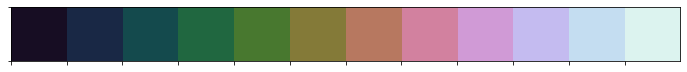

In [10]:
# create pallette for cells
current_palette = sns.color_palette('cubehelix',12)
sns.palplot(current_palette)
cells=core_reg['Cell'].unique()
colors=current_palette
res = {cells[i]: colors[i] for i in range(len(cells))} 

In [12]:
def biomass_yrs(core):
    global core_2017
    global core_2019
    core_2017=core.loc[core['year'] =='2017'].copy().reset_index()
    core_2019=core.loc[core['year']=='2019'].copy().reset_index()
    return core_2017,core_2019

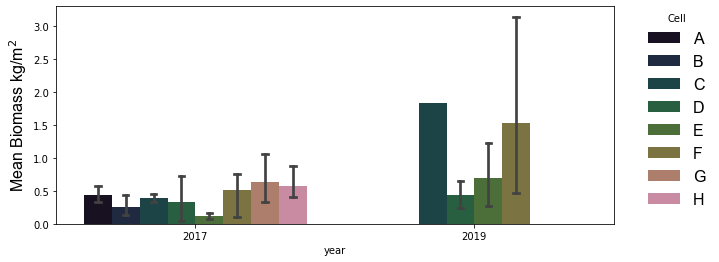

In [13]:
#barplot to explore mean biomass by cell and year
fig,axes = plt.subplots(1,sharex=True,figsize= (10,4))
sns.barplot(x="year", y="MEAN_Bioma", data=core_reg,hue="Cell",palette=res,capsize=0.02)
axes.set_ylabel("Mean Biomass kg/m$^2$", **axis_font)
plt.legend(title="Cell",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop=font_prop, numpoints=1,frameon=False)
# plt.savefig('barplots.pdf',bbox_inches='tight')

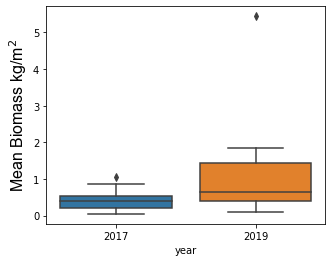

In [14]:
#boxplots to explore biomass by year
fig,axes = plt.subplots(1,sharex=True,figsize= (5,4))
sns.boxplot(x="year", y="MEAN_Bioma", data=core_reg)
axes.set_ylabel("Mean Biomass kg/m$^2$", **axis_font)
# plt.savefig('boxplots_bio.pdf',bbox_inches='tight')

In [15]:
# create separate dataframes for 2017 and 2019
core_2017,core_2019=biomass_yrs(core_reg)

#print mean biomass for 2017 and 2019
print(core_2017['MEAN_Bioma'].mean())
print(core_2019['MEAN_Bioma'].mean())

0.4073795416666666
1.1331238461538462


[5.4412400000000005]
[1.054611]


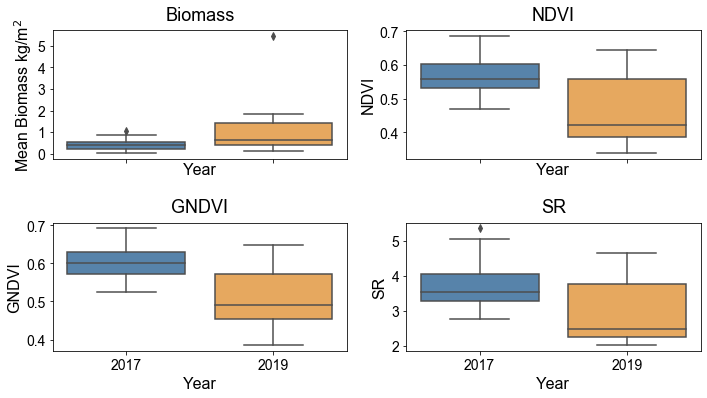

In [16]:
# plot boxplots of 2017 and 2019 data, print outliers

data=core_reg
biomass_yrs(data)

fig,axes = plt.subplots(2,2,sharex=True,figsize= (10,5))
fig.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.2)
plt.subplots_adjust(hspace = 0.5)

sns.boxplot(x="year", y="MEAN_Bioma", data=data,ax=axes[0][0],palette=col_list_palette)
axes[0][0].set_ylabel("Mean Biomass kg/m$^2$", **axis_font)
axes[0][0].set_title("Biomass", **title_font)

sns.boxplot(x="year", y="NDVI", data=data,ax=axes[0][1],palette=col_list_palette)
axes[0][1].set_ylabel("NDVI", **axis_font)
axes[0][1].set_title("NDVI", **title_font)

sns.boxplot(x="year", y="SR", data=data,ax=axes[1][1],palette=col_list_palette)
axes[1][1].set_ylabel("SR", **axis_font)
axes[1][1].set_title("SR", **title_font)

sns.boxplot(x="year", y="GNDVI", data=data,ax=axes[1][0],palette=col_list_palette)
axes[1][0].set_ylabel("GNDVI", **axis_font)
axes[1][0].set_title("GNDVI", **title_font)

#get outliers
from matplotlib.cbook import boxplot_stats
outliers_2019 = [y for stat in boxplot_stats(core_2019['MEAN_Bioma']) for y in stat['fliers']]
outliers_2017 = [y for stat in boxplot_stats(core_2017['MEAN_Bioma']) for y in stat['fliers']]

axe = axes.ravel()
for a in axe:
    a.set_xlabel("Year", **axis_font)
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(14)  

print(outliers_2019)
print(outliers_2017)
plt.savefig('boxplots.pdf',bbox_inches='tight')

In [17]:
#drop outliers
dum = core_reg[~core_reg.MEAN_Bioma.isin(outliers_2019)] #drop 2019 outliers
core_reg_no= dum[~dum.MEAN_Bioma.isin(outliers_2017)] #drop 2017 outliers
core_reg_no=core_reg_no.reset_index()
print("# outliers dropped = " +str(len(core_reg)-len(core_reg_no)))

# outliers dropped = 2


In [18]:
def scatter(data,title):
    fig,axes = plt.subplots(1,3,sharey=True,figsize= (9,2))
    fig.subplots_adjust(left=0.09, bottom=0.01, right=0.99, top=0.99, wspace=0.2)
    plt.subplots_adjust(hspace = 0.4)
    
    palette= res
    s=50
    sns.scatterplot(x="NDVI", y="MEAN_Bioma", data=data,hue="Cell",ax=axes[0],s=s,palette=palette)
    axes[0].set_ylabel("Mean Biomass kg/m$^2$", **axis_font)
    axes[0].set_xlabel("NDVI", **axis_font)
    axes[0].set_xlim(0,1)
    axes[0].legend_.remove()
    
    sns.scatterplot(x="GNDVI", y="MEAN_Bioma", data=data,hue="Cell",ax=axes[1],s=s,palette=palette)
    axes[1].set_ylabel("Mean Biomass kg/m$^2$", **axis_font)
    axes[1].set_xlabel("GNDVI", **axis_font)
    axes[1].set_xlim(0,1)
    axes[1].set_title(title,pad=15,**title_font)
    axes[1].legend_.remove()
    
    sns.scatterplot(x="SR", y="MEAN_Bioma", data=data,hue="Cell",ax=axes[2],s=s,palette=palette)
    axes[2].set_ylabel("Mean Biomass kg/m$^2$", **axis_font)
    axes[2].set_xlabel("SR", **axis_font)
    axes[2].set_xlim(0,6)
    axes[2].legend_.remove()

    axe = axes.ravel()
    for a in axe:
        for label in (a.get_xticklabels() + a.get_yticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(14)  

    h1,l1 = axes[0].get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(h1,l1):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    fig.legend(handle_list, label_list,bbox_to_anchor=(1.2,1.7),prop=font_prop, numpoints=1,frameon=False)

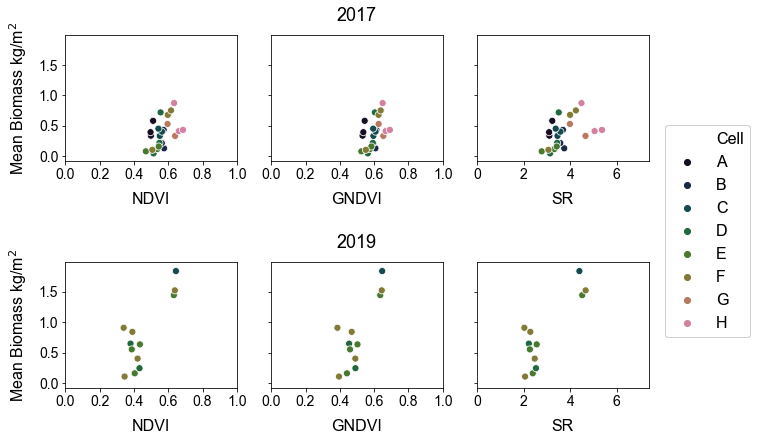

In [19]:
years=core_reg_no.year.unique()
veg=['NDVI','GNDVI','SR']
fig,axes = plt.subplots(2,3,sharey=True,figsize= (9,5))
fig.subplots_adjust(left=0.09, bottom=0.01, right=0.99, top=0.99, wspace=0.2)
plt.subplots_adjust(hspace = 0.8)
palette= res
s=50
y="MEAN_Bioma"

for j, y in enumerate(years):
    dum2 = core_reg_no[core_reg_no.year ==y]
    for i, v in enumerate(veg):
        sns.scatterplot(x=v, y="MEAN_Bioma", data=dum2,hue="Cell",s=s,palette=palette,ax=axes[j][i])
        axes[j][i].legend_.remove()
        axes[j][i].set_xlim(0,1)
        axes[j][2].set_xlim(0,core_reg_no[v].max()+2)
        axes[0][0].set_ylabel("Mean Biomass kg/m$^2$", labelpad=10,**axis_font)
        axes[1][0].set_ylabel("Mean Biomass kg/m$^2$",labelpad=10, **axis_font)
        axes[j][i].set_xlabel(v, labelpad=10,**axis_font)
        axes[j][1].set_title(y,pad=10,**title_font)

        axe = axes.ravel()
        for a in axe:
            for label in (a.get_xticklabels() + a.get_yticklabels()):
                label.set_fontname('Arial')
                label.set_fontsize(14)  

    h1,l1 = axes[0][0].get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(h1,l1):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    fig.legend(handle_list, label_list,bbox_to_anchor=(1.17,0.9),prop=font_prop, numpoints=1,frameon=True)

# Test linear model assumptions 

In [20]:
def test_assumptions(data,index):

    print(index)
    y = np.array(data['MEAN_Bioma']) 
    X = np.array(data[index]) 
    df = pd.DataFrame({'x':X, 'y':y,'const':1})

    #ols regression
    reg = smf.ols('y~x', data=df).fit()
    #predict y with regression
    pred_val = reg.fittedvalues.copy()
    # define true value
    true_val = data['MEAN_Bioma'].values.copy()
    # compute residuals
#     # plot residuals
#     fig, ax = plt.subplots(figsize=(6,2.5))
#     _ = ax.scatter(residual, pred_val)
#     plt.title('predicted value vs. residuals')
    residual = true_val - pred_val
    
    def het_breuschpagan(residual):
        r"""
        Breusch-Pagan Lagrange Multiplier test for heteroscedasticity

        The tests the hypothesis that the residual variance does not depend on
        the variables in x

        **Implementation**

        This is calculated using the generic formula for LM test using $R^2$
        (Greene, section 17.6) and not with the explicit formula
        (Greene, section 11.4.3).
        The degrees of freedom for the p-value assume x is full rank.

        References
        ----------
        .. [1] Greene, W. H. Econometric Analysis. New Jersey. Prentice Hall;
           5th edition. (2002).
        .. [2]  Breusch, T. S.; Pagan, A. R. (1979). "A Simple Test for
           Heteroskedasticity and Random Coefficient Variation". Econometrica.
           47 (5): 1287â€“1294.
        """

        # test for homoscedasticity
        #Small p-value  = violation of homoscedasticity.
        #Heteroscedasticity (the violation of homoscedasticity) is present when 
        #the size of the error term differs across values of an independent variable.
        _, pval, fval, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(residual, df[['x','const']])
#         print("fval = "+str(fval))
        print("Breusch-Pagan Lagrange Multiplier pval = "+str(pval))
        print('if high p-value = homoscedasticity assumption met')
        print('----')

    def harvey_collier():
        """
        Harvey Collier test for linearity

        The Null hypothesis is that the regression is correctly modeled as linear.

        This test is a t-test that the mean of the recursive ols residuals is zero.
        Calculating the recursive residuals might take some time for large samples.
        """

        # test linearity of data
        print("Harvey Collier pval = "+str(sms.linear_harvey_collier(reg)))
        print('if high p-value = linear assumption met')
        print('----')

    def residuals():
        # test normality of data

        _, (__, ___, r) = sp.stats.probplot(residual,fit=True);
        print("residual normality r^2 = " + str(r**2))
        print('if high r^2, residuals are normal')
        print('----')
        print('----')
        
    def normal():
        # test normality of data


        JB, JBpv, ___, __ = smt.jarque_bera(residual)
        print("Jarque-Bera statistic = " + str(JB))
        print("Jarque-Bera pval = " + str(JBpv))
        print('if high p-value = normal assumption met')
        print('----')
        print('----')
    
    
    
    harvey_collier()
    het_breuschpagan(residual)
    residuals()
    normal()

In [21]:
years=core_reg_no.year.unique()
veg=['NDVI','GNDVI','SR']


for j, y in enumerate(years):
    print(y)
    dum2 = core_reg_no[core_reg_no.year ==y]
    for i,v in enumerate(veg):
        test_assumptions(dum2,v)

2017
NDVI
Harvey Collier pval = Ttest_1sampResult(statistic=-0.3770581186954734, pvalue=0.7103088290257435)
if high p-value = linear assumption met
----
Breusch-Pagan Lagrange Multiplier pval = 0.3411089978531856
if high p-value = homoscedasticity assumption met
----
residual normality r^2 = 0.9258117469053784
if high r^2, residuals are normal
----
----
Jarque-Bera statistic = 2.0259072416949433
Jarque-Bera pval = 0.3631448019380579
if high p-value = normal assumption met
----
----
GNDVI
Harvey Collier pval = Ttest_1sampResult(statistic=-0.12958119145524802, pvalue=0.8982597638138182)
if high p-value = linear assumption met
----
Breusch-Pagan Lagrange Multiplier pval = 0.6342625806426483
if high p-value = homoscedasticity assumption met
----
residual normality r^2 = 0.9253734515937686
if high r^2, residuals are normal
----
----
Jarque-Bera statistic = 2.109236850329733
Jarque-Bera pval = 0.3483253141257624
if high p-value = normal assumption met
----
----
SR
Harvey Collier pval = Ttest

# OLS and WLS regressions - train test

In [22]:
def traintest(data,index):
    y = data['MEAN_Bioma'] 
    X = data[index]
    
    #separate into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,shuffle=True,random_state=7) #7
    diff=np.max(y_test)-np.min(y_test)
    df_train = pd.DataFrame({'x':X_train, 'y':y_train,'const':1})
    df_test = pd.DataFrame({'x':X_test, 'y':y_test,'const':1})
    return df_test,df_train,diff
    
def OLS(data,index):
    df_test,df_train,diff=traintest(data,index)
    #fit OLS regression on training data
    lmod = smf.ols('y~x-1', data=df_train).fit() # remove y intercept (-1)
    #predict y using ols regression
    y_pred=lmod.predict(df_test.x)
    y_test=df_test.y

    return lmod,y_pred,y_test,diff

def print_OLS(data,index):
        #print metrics
#     print(index)
    print('-------')
    lmod,y_pred,y_test,diff=OLS(data,index)
    print('OLS r2  %.2f' %  metrics.r2_score(y_test, y_pred))  
    print('OLS Mean Absolute Error %.2f' %  metrics.mean_absolute_error(y_test, y_pred))  
#     print('OLS Mean Squared Error %.2f' %  metrics.mean_squared_error(y_test, y_pred))  
    print('OLS Root Mean Squared Error %.2f' %  np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('OLS Normalized Root Mean Squared Error %.2f' 
          % np.float64(sqrt(mean_squared_error(y_test,y_pred))/diff))


def WLS(data,index):

    df_test,df_train,diff=traintest(data,index)
    # get weights from covariance matrix, first use OLS
    lmod,y_pred,y_test,diff=OLS(data,index)
    gamma = np.mean(np.abs(lmod.resid) - df_train.x)
    weights=np.sqrt(abs(1/(gamma+df_train.x)))

    #fit WLS regression using weights
    mod_wls = sm.WLS(df_train.y, df_train.x).fit()
    #predict y using wls regression
    y_pred=mod_wls.predict(df_test.x)
    y_test=df_test.y
    
    return mod_wls,y_pred,y_test,diff
    
def print_WLS(data,index):
#     print(index)
    print('-------')
    mod_wls,y_pred,y_test,diff=WLS(data,index)
    
    #print metrics
#     print('WLS r2  %.2f' % mod_wls.rsquared) #does not include y-intercept!
    print('WLS r2  %.2f' %  metrics.r2_score(y_test, y_pred))  
    print('WLS Mean Absolute Error %.2f' %  metrics.mean_absolute_error(y_test, y_pred))  
#     print('WLS Mean Squared Error %.2f' %  metrics.mean_squared_error(y_test, y_pred))  
    print('WLS Root Mean Squared Error %.2f' %  np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('WLS Normalized Root Mean Squared Error %.2f' 
          % np.float64(sqrt(mean_squared_error(y_test,y_pred))/diff))

In [23]:
years=core_reg_no.year.unique()
veg=['SR']


for j, y in enumerate(years):
    dum2 = core_reg_no[core_reg_no.year ==y]
    print(y)
    print("  ")
    for i,v in enumerate(veg):
        print(v)
        print_OLS(dum2,v)
        print("  ")

2017
  
SR
-------
OLS r2  0.19
OLS Mean Absolute Error 0.21
OLS Root Mean Squared Error 0.24
OLS Normalized Root Mean Squared Error 0.29
  
2019
  
SR
-------
OLS r2  0.54
OLS Mean Absolute Error 0.28
OLS Root Mean Squared Error 0.34
OLS Normalized Root Mean Squared Error 0.25
  


# test sensitivity to random state - bias

In [24]:

def dict_to_df(d,name):
    
    df=pd.DataFrame(d.items(), columns=[name, 'value'])
    return df

def random_state_ols(data,index):
    
    """
    
    Tests sensitivity to random state 
    initial choice of data for training and testing

    """
    
    global ols_r2,ols_nrmse
    r2=dict()
    nrmse =dict()
    y = data['MEAN_Bioma'] 
    X = data[index]
    
    # splits X, Y  input data into X and y training and testing sets
    randomstate=[0,1,2,3,4,5,6,7,8,9]
    for i in randomstate:
         # splits X, Y  input data into X and y training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y, 
                                                            test_size=0.30,
                                                            shuffle=True, 
                                                            random_state=i) 
    
        df_train = pd.DataFrame({'x':X_train, 'y':y_train,'const':1})
        df_test = pd.DataFrame({'x':X_test, 'y':y_test,'const':1})
        diff=np.max(df_test.y)-np.min(df_test.y)
        #fit OLS regression on training data
        lmod = smf.ols('y~x-1', data=df_train).fit()
        #predict y using ols regression
        y_pred=lmod.predict(df_test.x)
        y_test=df_test.y
        r2_val= metrics.r2_score(y_test, y_pred)  
        mae_val = metrics.mean_absolute_error(y_test, y_pred)  
        mse_val = metrics.mean_squared_error(y_test, y_pred)  
        nrmse_val = np.float64(sqrt(mean_squared_error(y_test,y_pred))/diff)
        
        r2.update({i:r2_val})
        nrmse.update({i:nrmse_val})
    
    ols_r2=dict_to_df(r2,'r2')
    ols_nrmse =dict_to_df(nrmse,'nrmse')
    
    
#     print(np.mean(scores_all['value']))

    print("mean r2 = " + str(ols_r2["value"].mean()))
    print("mean nrmse = " + str(ols_nrmse["value"].mean()))
    print("------")
    
    return ols_r2,ols_nrmse


In [25]:
years=core_reg_no.year.unique()
veg=['SR']

for j, y in enumerate(years):
    dum2 = core_reg_no[core_reg_no.year ==y]
    print(y)
    print("  ")
    for i,v in enumerate(veg):
        print(v)
        random_state_ols(dum2,v)
        print("  ")

2017
  
SR
mean r2 = 0.07722127435725998
mean nrmse = 0.3155534574628202
------
  
2019
  
SR
mean r2 = 0.4908890687107178
mean nrmse = 0.2678537481227342
------
  


# Train and test on all the data

In [30]:
def OLS_all(data,index):
    """
    
    Train on all the data
    
    """
    y = data['MEAN_Bioma'] 
    X = data[index]
    df = pd.DataFrame({'x':X, 'y':y,'const':1})
    #     fit OLS regression on all data
    lmod = smf.ols('y~x-1', data=df).fit()

    print('Biomass = : {} x '.format(lmod.params[0]) +str(index))
    return lmod


def OLS_insample_plot(data,index,color,year):
    """

    """
    lmod=OLS_all(data,index)
    y = data['MEAN_Bioma'] 
    X = data[index]
    df = pd.DataFrame({'x':X, 'y':y,'const':1})
    def ols_reg(x):
        return lmod.params[0]*x
    df['y_pred']=ols_reg(df['x'])
    diff=np.max(df.y)-np.min(df.y)
    
    sns.set_context("paper", font_scale=1.6)
    ax=sns.scatterplot("x", 
                       "y",
                       data=df,
                       color=color,
                       marker='X',
                       s=100, 
                       alpha=0.8,
                       lw=5,
                       edgecolors='black'
                       )  
    ax.plot(df.x,df.y_pred,color=color,label="Biomass - SR (OLS) "+str(year))
    ax.set_xlim(0,max(df.x)+1)
    ax.set_ylim(0,max(df.y)+1)
    ax.legend()
        
    ax.set_xlabel('SR')
    ax.set_ylabel('Biomass, $kg/m^2$')
    ax.set_title(year,fontdict = {'fontsize' : 15})
    nrmse = np.float64(sqrt(mean_squared_error(df.y,df.y_pred))/diff)
    
    print ("r2 = " + str(metrics.r2_score(df.y, df.y_pred)))
    print("mean nrmse = " + str(nrmse))

Biomass = : 0.10390719601663037 x SR
r2 = 0.17529378024713904
mean nrmse = 0.24849533489403675
Biomass = : 0.29093077493531927 x SR
r2 = 0.601686935923435
mean nrmse = 0.1965173332243863


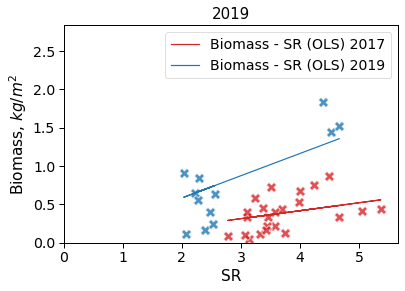

In [31]:
years=core_reg_no.year.unique()
veg=['SR']
colors=['C33','C0','C55']

for j, y in enumerate(years):
    dum2 = core_reg_no[core_reg_no.year ==y]
#     print(y)
    OLS_insample_plot(dum2,veg[0],colors[j],y)
    plt.savefig('OLS.pdf',bbox_inches='tight')

In [32]:
def confidence(data,index):
    """
    
        Based on statsmodel CI function: Compute the confidence interval of the fitted parameters.

        Parameters
        ----------
        alpha : float, optional
            The `alpha` level for the confidence interval. The default
            `alpha` = .05 returns a 95% confidence interval.
        cols : array_like, optional
            Columns to included in returned confidence intervals.

        Notes
        -----
        The confidence interval is based on Student's t-distribution.
        
    """
    
    y = data['MEAN_Bioma'] 
    X = data[index]
    df = pd.DataFrame({'x':X, 'y':y,'const':1})
    lmod = OLS_all(data,index)
    
    slope=lmod.params[0]
    lower_ci=lmod.conf_int(0.05, cols=None)[0][0]
    
    upper_ci=lmod.conf_int(0.05, cols=None)[1][0]
    
    # df['slope_ci']=mod_wls.conf_int(0.05)

    def y_lower(x):
        return (lmod.params[0]-lower_ci)*x
    def y_upper(x):
        return (lmod.params[0]+upper_ci)*x
    def ols_reg(x):
        return lmod.params[0]*x
    x_pred = np.linspace(1.8, 6, 50)
#     df_pred = pd.DataFrame({'x_pred':x_pred})
    
    y_pred=ols_reg(x_pred)
    y_pred_lower = y_lower(x_pred)
    y_pred_upper = y_upper(x_pred)
    
#     df['y_lower']=y_lower(df['x'])
#     df['y_upper']=y_upper(df['x'])

    return df,lmod,lower_ci,upper_ci,x_pred,y_pred_lower,y_pred_upper,y_pred,y_pred

2017
Biomass = : 0.10390719601663037 x SR
2019
Biomass = : 0.29093077493531927 x SR


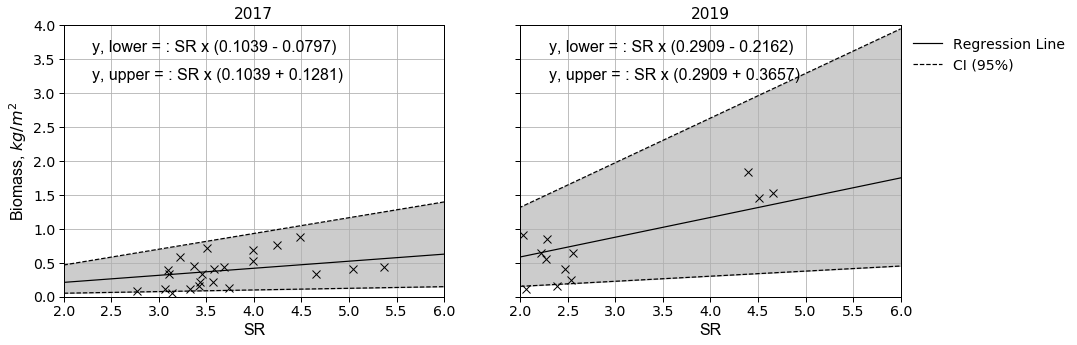

In [33]:
fig,axes = plt.subplots(1,2,sharex=True,sharey=True,figsize= (15,5))
axe = axes.ravel()
years=core_reg_no.year.unique()
veg=['SR']

for i, y in enumerate(years):
    print(y)
    dum2 = core_reg_no[core_reg_no.year ==y]
    df,lmod,lower_ci,upper_ci,x_pred,y_pred_lower,y_pred_upper,y_pred,y_pred = confidence(dum2,veg[0])
    #   plot points
    axe[i].plot(df.x,df.y,'x',markersize=8,c='black')
    #   plot line of best fit
    axe[i].plot(x_pred,y_pred,'r-',c='black',label="Regression Line")
    axe[i].plot(x_pred,y_pred_upper,'k--',label='CI (95%)')
    axe[i].plot(x_pred,y_pred_lower,'k--')
    axe[i].fill_between(x_pred,y_pred_lower, y_pred_upper,alpha=0.2,color='black')
    axe[i].set_xlim(2,6)
    axe[i].set_ylim(0,4)
    axe[i].set_title(y)
    axe[i].set_xlabel("SR",**axis_font)
    axe[i].set_ylabel("Biomass, $kg/m^2$",**axis_font)
    axe[1].set_ylabel("")
    axe[i].grid(True)
    text_lower=('y, lower = : SR x ({} - {}) '.format(round(lmod.params[0],4), 
                                       (round(lower_ci,4))))
    text_upper=('y, upper = : SR x ({} + {}) '.format(round(lmod.params[0],4), 
                                       (round(upper_ci,4))))
    
#     text_upper=('y, upper = : ({} + {}) x SR '.format(round(lmod.params[0],4), 
#                                        (round(upper_ci,4))))
    axe[i].text(2.3,3.6, text_lower,**axis_font)
    axe[i].text(2.3,3.2, text_upper,**axis_font)
#     print((round(lmod.params[0],4) - (round(lower_ci,4))))
#     print((round(lmod.params[0],4) + (round(upper_ci,4))))

#     axe[i].text(2.5,3.6, text_lower,**axis_font)
#     print(np.mean(lower_ci+upper_ci))

plt.legend(loc='best',bbox_to_anchor=(1,1),frameon=False)
plt.savefig('WLS_ci.pdf',bbox_inches='tight')